# Convolutional Neural Network (CNN) Hyperparameter Tuning

## Hyperparameters that I am tuning

In this notebook, I am implementing a convolutional neural network to classify objects in the Fashion MNIST Dataset. I am also experimenting with parameters to determine which combination of hyperparameters leads to the best accuracy by percentage of correct classifications/total classifications and most efficient training as measured in seconds to train the model. For this project, the three parameters I will focus on are:

1. **Filter Size** - Convolutional filters are a small matrix that is slid over an image to extract important features such as edges, texture, color, etc. Filter size refers to the size of the matrix being passed over the image. In this instance, we will be experimenting with 3X3 and 5X5 filters. Larger filters capture more spatial context but with less local detail, while smaller filters capture more detailed patterns.
2. **Output Channels** (Features) - Output Channels or features refer to unique patterns that a CNN can extract from an image. These channels are found by applying the convolutional filter which detects a specific pattern in the input image. The baseline model will have 32 features, and I will experiment with halving and doubling these features. More output channels can be useful in identifying complex patterns in an image but it can lead to it increases the computational requirement and can lead to overfitting as spurious patterns may be picked up.
3. **Batch Size** - Batch sizes refer to the number training samples that are processed together during one forward and backward pass thorugh the sample. Smaller batch sizes lead to more frequent updating of the model's weights. Batch sizes generally range between 32 and 256, but for this, I will be trying three different batch size: 32, 64, and 128.

# Expectation
### Accuracy
Before running the model and hypertuning the parameters, I would predict that our most accurate model will have the following parameters: Filter_size = 3 X 3, Features = 64, and batch size = 32. The reason for this is that these will provide the most information as the filter size is smaller leading meaning it would be able to pick up on more detail, the number of features is the highest, and the batch size is the smallest meaning weights will be updated more frequently. Now an issue could be overfitting, so it's possible that these exact parameters won't be the exact outcome but I would say the general idea of smaller filter size, high features, and smaller batch size will lead to the best results on accuracy. 

### Training Time
I do not expect the result with the highest accuracy to have the best result as hyperparameters that may lead to better accuracy may be more computationally intensive. In this instance, a larger filter size leading to quicker sliding over the image, less features, and a larger batch size reducing the amount of times the model is updated should lead to the fastest result.

# Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import polars as pl
import numpy as np
import time
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a CNN using PyTorch

In [72]:
# Custom dataset class for Fashion MNIST csv files
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pl.read_csv(csv_file)
        self.labels = data.select(pl.col(data.columns[0])).to_numpy().flatten()
        self.images = data.select(pl.col("*").exclude(data.columns[0])).to_numpy().astype('float32') / 255.0
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(1, 28, 28)
        image = torch.FloatTensor(image)
        label = self.labels[idx]
        return image, label

class FashionCNN(nn.Module):
    def __init__(self, conv_filter_size=3, conv1_features=32, conv2_features=64):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

def calculate_loss(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
    
    return total_loss / total_samples

def train_model(model, train_loader, val_loader, test_loader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    start_time = time.time()
    model = model.to(device)
    
    # For storing metrics
    metrics = []
    
    for epoch in range(10):  # Fixed 10 epochs for consistent comparison
        # Training
        model.train()
        train_loss = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
        
        # Calculate average losses
        avg_train_loss = train_loss / total_samples
        avg_val_loss = calculate_loss(model, val_loader, criterion, device)
        
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        })
        
        print(f"Epoch: {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    training_time = time.time() - start_time
    
    # Calculate final test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_accuracy = 100 * correct / total
    
    return metrics, final_accuracy, training_time

## Set up a function that will iterate through all combinations of our hyperparameters.

The hyperparameters we would like to test are as follows:
1. **Filter Size**- (3X3), (5X5)
2. **Channels**- 16, 32, 64 (32 is our baseline value, 16 is half and 64 is double)
3. **Batch Size**- 32, 64, 128

In total, since we have 2 options for filter size and 3 options for channels and batch size, we will have possible combinations (2 X 3 X 3  = 18). The run_experiments function below will iterate through all 18 combinations which may not be feasible if we had more values or hyperparameters to test. The baseline model has a 3X3 filter size, 32 channels in the first convolutional layer, and a batch size of 64. From there it will iterate through batch size, channels, and then filter size. Accuracy and Training Time are the two key metrics I am focusing on optimizing in this analysis. 

The epoch is set to 10 which means that our model will run through our dataset 10 times in total during our training. At the end of each epoch, we will see the cross-entropy loss on our train data and validation data. In the end, the model will be run on our test data and return the accuracy of the model.

In [44]:
def run_experiments(train_file, test_file, device='cuda', seed = 42):
    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    # Load datasets
    full_dataset = FashionMNISTDataset(train_file)
    test_dataset = FashionMNISTDataset(test_file)
    
    # Split training data into train and validation (1/8th split)
    train_size = int((7/8) * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    # Experimental parameters
    filter_sizes = [3, 5]
    feature_sizes = [(16, 32), (32, 64), (64, 128)]  # (conv1_features, conv2_features)
    batch_sizes = [32, 64, 128]
    
    # Store all results
    all_results = []
    
    # First run baseline model (3x3 filter, 32/64 features, batch size 64)
    print("\nRunning baseline model:")
    baseline_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    baseline_val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    baseline_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    baseline_model = FashionCNN()
    baseline_metrics, baseline_accuracy, baseline_time = train_model(
        baseline_model, baseline_loader, baseline_val_loader, baseline_test_loader, device=device
    )
    
    print(f"\nBaseline Results:")
    print(f"Test Accuracy: {baseline_accuracy:.2f}%")
    print(f"Training Time: {baseline_time:.2f} seconds")
    
    # Run factorial experiment
    print("\nRunning factorial experiment...")
    
    for filter_size, (conv1_feat, conv2_feat), batch_size in product(filter_sizes, feature_sizes, batch_sizes):
        print(f"\nConfiguration:")
        print(f"Filter Size: {filter_size}x{filter_size}")
        print(f"Features: {conv1_feat}/{conv2_feat}")
        print(f"Batch Size: {batch_size}")
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Create and train model
        model = FashionCNN(conv_filter_size=filter_size, 
                          conv1_features=conv1_feat, 
                          conv2_features=conv2_feat)
        
        metrics, accuracy, train_time = train_model(
            model, train_loader, val_loader, test_loader, device=device
        )
        
        all_results.append({
            'filter_size': filter_size,
            'conv1_features': conv1_feat,
            'conv2_features': conv2_feat,
            'batch_size': batch_size,
            'test_accuracy': accuracy,
            'training_time': train_time,
            'metrics': metrics
        })
        
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(f"Training Time: {train_time:.2f} seconds")
    
    return baseline_metrics, baseline_accuracy, baseline_time, all_results

In [45]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run all combinations
baseline_metrics, baseline_accuracy, baseline_time, results = run_experiments(
    train_file='fashion-mnist_train.csv',
    test_file='fashion-mnist_test.csv',
    device=device
)

# Create results DataFrame to keep tabs on hyperparameters and performance
experiment_data = []

for result in results:
    experiment_data.append({
        'Filter Size': f"{result['filter_size']}x{result['filter_size']}",
        'Conv1 Features': result['conv1_features'],
        'Conv2 Features': result['conv2_features'],
        'Batch Size': result['batch_size'],
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

results_df = pl.DataFrame(experiment_data)

# Print results
print("\nBaseline Model Results:")
print(f"Test Accuracy: {baseline_accuracy:.2f}%")
print(f"Training Time: {baseline_time:.2f} seconds")
print("\nBaseline Training Metrics:")
baseline_metrics_df = pl.DataFrame(baseline_metrics)
print(baseline_metrics_df)

print("\nFactorial Experiment Results:")
print(results_df)

# Find best performing configurations based on accuracy and training time
best_accuracy = max(results, key=lambda x: x['test_accuracy'])
fastest_training = min(results, key=lambda x: x['training_time'])

print("\nBest Accuracy Configuration:")
print(f"Filter Size: {best_accuracy['filter_size']}x{best_accuracy['filter_size']}")
print(f"Features: {best_accuracy['conv1_features']}/{best_accuracy['conv2_features']}")
print(f"Batch Size: {best_accuracy['batch_size']}")
print(f"Accuracy: {best_accuracy['test_accuracy']:.2f}%")
print(f"Training Time: {best_accuracy['training_time']:.2f}s")

print("\nFastest Training Configuration:")
print(f"Filter Size: {fastest_training['filter_size']}x{fastest_training['filter_size']}")
print(f"Features: {fastest_training['conv1_features']}/{fastest_training['conv2_features']}")
print(f"Batch Size: {fastest_training['batch_size']}")
print(f"Accuracy: {fastest_training['test_accuracy']:.2f}%")
print(f"Training Time: {fastest_training['training_time']:.2f}s")


Running baseline model:
Epoch: 1, Training Loss: 0.5334, Validation Loss: 0.3824
Epoch: 2, Training Loss: 0.3521, Validation Loss: 0.3311
Epoch: 3, Training Loss: 0.3004, Validation Loss: 0.3040
Epoch: 4, Training Loss: 0.2724, Validation Loss: 0.2696
Epoch: 5, Training Loss: 0.2458, Validation Loss: 0.2661
Epoch: 6, Training Loss: 0.2268, Validation Loss: 0.2626
Epoch: 7, Training Loss: 0.2096, Validation Loss: 0.2731
Epoch: 8, Training Loss: 0.1913, Validation Loss: 0.2678
Epoch: 9, Training Loss: 0.1742, Validation Loss: 0.2516
Epoch: 10, Training Loss: 0.1603, Validation Loss: 0.2392

Baseline Results:
Test Accuracy: 91.93%
Training Time: 79.97 seconds

Running factorial experiment...

Configuration:
Filter Size: 3x3
Features: 16/32
Batch Size: 32
Epoch: 1, Training Loss: 0.4911, Validation Loss: 0.3514
Epoch: 2, Training Loss: 0.3260, Validation Loss: 0.3226
Epoch: 3, Training Loss: 0.2775, Validation Loss: 0.2788
Epoch: 4, Training Loss: 0.2433, Validation Loss: 0.2514
Epoch: 5,

# Accuracy Results

Below, you can see the first five rows pf a data frame with the models sorted in descending order based on their accuracy. As expected, A high number of output channels/features and a lower batch size tended to produce better results; however, I incorrectly predicted that a smaller filter size would lead to better results. Out of the top 5 accuracy scores, 4 of them had filter size set to a 5 X 5 matrix rather than the 3 X 3 matrix. This may be due to the fact that 5 X 5 filter can take in more spatial data leading to it capturing more relavant features whereas a 3 X 3 may have a limited scope. It is also interesting to note that the highest performing 3 X 3 model had a low number of features. 

In [52]:
results_df_sorted_accuracy = results_df.sort("Test Accuracy", descending=True)
# Top Five Results for Accuracy
results_df_sorted_accuracy.head()

Filter Size,Conv1 Features,Conv2 Features,Batch Size,Test Accuracy,Training Time
str,i64,i64,i64,f64,f64
"""5x5""",64,128,32,92.31,128.349103
"""5x5""",32,64,32,92.03,130.149438
"""3x3""",16,32,32,92.01,141.66068
"""5x5""",16,32,32,91.92,134.055948
"""5x5""",32,64,64,91.87,78.210815


# Training Time Results

The training time results partially matched with our predictions. What is clear from the table below is that batch size appears to have the biggest impact on training time which makes sense as it reduces the number of weights updated per epoch. This allows the model to go through the dataset much quicker but it does provide a negative impact to accuracy. Filter size and number of features doesn't seem to have much of an impact on the training time. Below, I have included some graphs to better illustrate the impact of these three hyperparameters on accuracy and training time.

In [53]:
results_df_sorted_train_time = results_df.sort("Training Time")
# Top 5 Results for Training Time
results_df_sorted_train_time.head()

Filter Size,Conv1 Features,Conv2 Features,Batch Size,Test Accuracy,Training Time
str,i64,i64,i64,f64,f64
"""5x5""",64,128,128,91.58,55.094167
"""3x3""",32,64,128,91.32,55.245621
"""5x5""",16,32,128,91.42,55.628229
"""5x5""",32,64,128,91.02,55.758594
"""3x3""",64,128,128,91.06,58.563795


Below you can see the average accuracy and training time for each for each of the hyperparameters. The accuracy graphs have their scale adjusted to between 90 and 94 to better show the differences between the each hyperparameter.

In [83]:
# Calculate average metrics for each filter size
filter_analysis = results_df.group_by('Filter Size').agg([
    pl.col('Test Accuracy').mean().alias('avg_accuracy'),
    pl.col('Training Time').mean().alias('avg_training_time')
])
print("\nFilter Size Analysis:")
print(filter_analysis)

# Calculate average metrics for each conv1 feature size
feature_analysis = results_df.group_by('Conv1 Features').agg([
    pl.col('Test Accuracy').mean().alias('avg_accuracy'),
    pl.col('Training Time').mean().alias('avg_training_time')
])
print("\nFeature Size Analysis (Conv1):")
print(feature_analysis)

# Calculate average metrics for each batch size
batch_analysis = results_df.group_by('Batch Size').agg([
    pl.col('Test Accuracy').mean().alias('avg_accuracy'),
    pl.col('Training Time').mean().alias('avg_training_time')
])
print("\nBatch Size Analysis:")
print(batch_analysis)


Filter Size Analysis:
shape: (2, 3)
┌─────────────┬──────────────┬───────────────────┐
│ Filter Size ┆ avg_accuracy ┆ avg_training_time │
│ ---         ┆ ---          ┆ ---               │
│ str         ┆ f64          ┆ f64               │
╞═════════════╪══════════════╪═══════════════════╡
│ 5x5         ┆ 91.731111    ┆ 88.198526         │
│ 3x3         ┆ 91.497778    ┆ 91.704987         │
└─────────────┴──────────────┴───────────────────┘

Feature Size Analysis (Conv1):
shape: (3, 3)
┌────────────────┬──────────────┬───────────────────┐
│ Conv1 Features ┆ avg_accuracy ┆ avg_training_time │
│ ---            ┆ ---          ┆ ---               │
│ i64            ┆ f64          ┆ f64               │
╞════════════════╪══════════════╪═══════════════════╡
│ 32             ┆ 91.535       ┆ 88.817758         │
│ 16             ┆ 91.63        ┆ 91.941763         │
│ 64             ┆ 91.678333    ┆ 89.095748         │
└────────────────┴──────────────┴───────────────────┘

Batch Size Analysis:
s

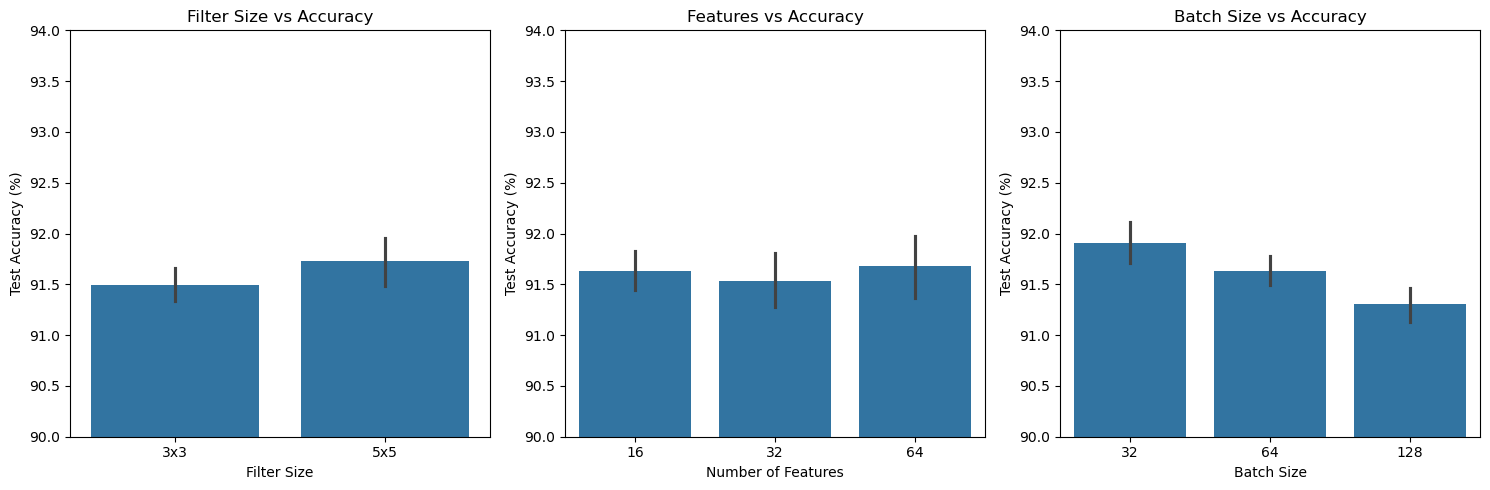

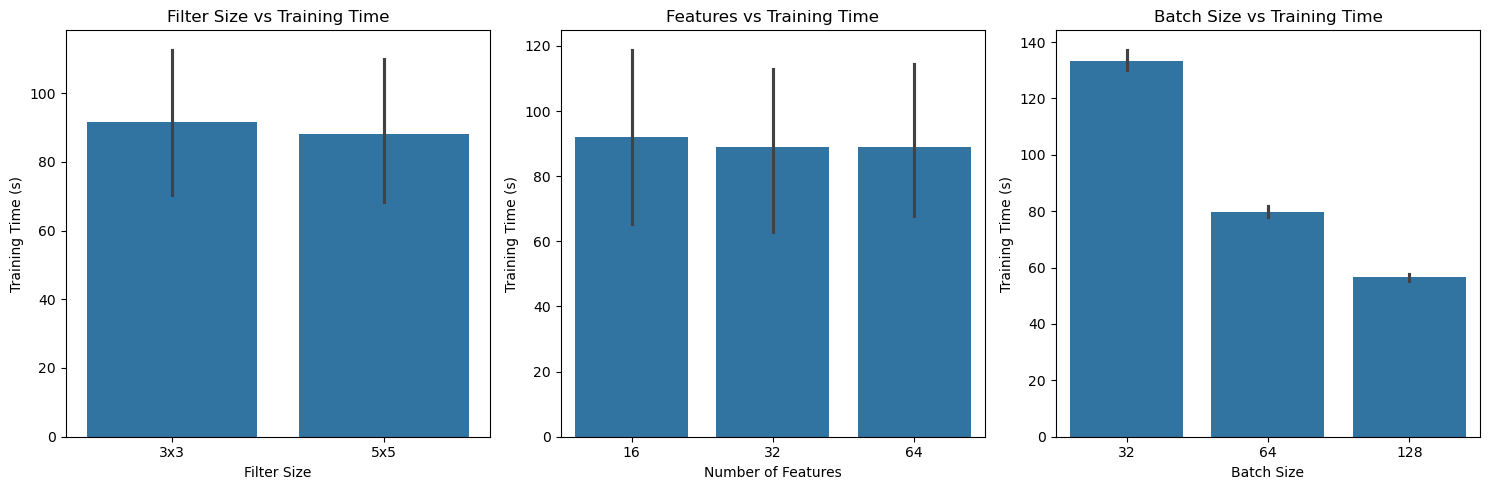

In [82]:
# Visualization
plt.figure(figsize=(15, 5))

# Filter Size Impact
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x='Filter Size', y='Test Accuracy')
plt.title('Filter Size vs Accuracy')
plt.xlabel('Filter Size')
plt.ylabel('Test Accuracy (%)')
plt.ylim(90, 94)

# Feature Size Impact
plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x='Conv1 Features', y='Test Accuracy')
plt.title('Features vs Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Test Accuracy (%)')
plt.ylim(90, 94)

# Batch Size Impact
plt.subplot(1, 3, 3)
sns.barplot(data=results_df, x='Batch Size', y='Test Accuracy')
plt.title('Batch Size vs Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy (%)')
plt.ylim(90, 94)

plt.tight_layout()
plt.show()

# Training Time Analysis
plt.figure(figsize=(15, 5))

# Filter Size Impact on Time
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x='Filter Size', y='Training Time')
plt.title('Filter Size vs Training Time')
plt.xlabel('Filter Size')
plt.ylabel('Training Time (s)')

# Feature Size Impact on Time
plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x='Conv1 Features', y='Training Time')
plt.title('Features vs Training Time')
plt.xlabel('Number of Features')
plt.ylabel('Training Time (s)')

# Batch Size Impact on Time
plt.subplot(1, 3, 3)
sns.barplot(data=results_df, x='Batch Size', y='Training Time')
plt.title('Batch Size vs Training Time')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (s)')

plt.tight_layout()
plt.show()